In [2]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# Настройка отображения
plt.style.use('default')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

# Настройка pandas для лучшего отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("dataset_telemetry.csv")
# Преобразуем timestamp в datetime, если еще не сделано
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Извлекаем месяц и год
df['month'] = df['timestamp'].dt.to_period('M')  # или dt.strftime('%Y-%m')
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

df.head(5)

,Unnamed: 0,userid,sessionid,timestamp,action,value,category,age,gender,city,month,year_month
0,0,user_10000,1,2021-12-30 12:28:45,category,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
1,1,user_10000,1,2021-12-30 12:29:10,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
2,2,user_10000,1,2021-12-30 12:29:25,product,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
3,3,user_10000,1,2021-12-30 12:29:26,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
4,4,user_10000,1,2021-12-30 12:29:34,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12


In [7]:
# Создаем копию данных для безопасности
df_analysis = df.copy()

# Преобразуем timestamp и добавляем месяц
df_analysis['timestamp'] = pd.to_datetime(df_analysis['timestamp'])
df_analysis['year'] = df_analysis['timestamp'].dt.year
df_analysis['month'] = df_analysis['timestamp'].dt.month
df_analysis['year_month'] = df_analysis['timestamp'].dt.strftime('%Y-%m')

# Вариант A: Стандартный ARPU
df_value_users = df_analysis.copy()

# Считаем ARPU
arpu_results = []
for month in sorted(df_value_users['year_month'].unique()):
    month_data = df_value_users[df_value_users['year_month'] == month]
    
    total_revenue = month_data['value'].sum()
    unique_payers = month_data['userid'].nunique()
    
    if unique_payers > 0:
        arpu = total_revenue / unique_payers
    else:
        arpu = 0
    
    arpu_results.append({
        'year_month': month,
        'total_revenue': total_revenue,
        'unique_payers': unique_payers,
        'ARPU': arpu,
        'avg_value_per_transaction': month_data['value'].mean() if len(month_data) > 0 else 0,
        'transactions_count': len(month_data)
    })

arpu_df = pd.DataFrame(arpu_results)

print("=" * 60)
print("ARPU по месяцам:")
print("=" * 60)
print(arpu_df.to_string(index=False))
print("\nСводная статистика:")
print(f"Средний ARPU за период: {arpu_df['ARPU'].mean():.2f}")
print(f"Максимальный ARPU: {arpu_df['ARPU'].max():.2f} ({arpu_df.loc[arpu_df['ARPU'].idxmax(), 'year_month']})")
print(f"Минимальный ARPU: {arpu_df['ARPU'].min():.2f} ({arpu_df.loc[arpu_df['ARPU'].idxmin(), 'year_month']})")

# Для каждого месяца считаем всех уникальных пользователей (не только плативших)
arpu_all_users = []

for month in sorted(df_analysis['year_month'].unique()):
    month_data = df_analysis[df_analysis['year_month'] == month]
    
    # Выручка за месяц
    month_revenue = month_data['value'].sum()
    
    # Все уникальные пользователи в месяце (даже те, кто ничего не купил)
    all_users = month_data['userid'].nunique()
    
    # Платящие пользователи
    paying_users = month_data[month_data['value'] > 0]['userid'].nunique()
    
    if all_users > 0:
        arpu_all = month_revenue / all_users
        arpu_paying = month_revenue / paying_users if paying_users > 0 else 0
    else:
        arpu_all = 0
        arpu_paying = 0
    
    arpu_all_users.append({
        'year_month': month,
        'total_revenue': month_revenue,
        'all_users': all_users,
        'paying_users': paying_users,
        'ARPU_all_users': arpu_all,
        'ARPU_paying_users': arpu_paying,
        'conversion_rate': (paying_users / all_users * 100) if all_users > 0 else 0
    })

arpu_complete_df = pd.DataFrame(arpu_all_users)

print("\n" + "=" * 80)
print("Расширенный анализ ARPU:")
print("=" * 80)
print(arpu_complete_df.to_string(index=False))

ARPU по месяцам:
year_month  total_revenue  unique_payers          ARPU  avg_value_per_transaction  transactions_count
   2021-12   7.424609e+07           2415  30743.724141                2482.233753               29911
   2022-01   5.169183e+08           2500 206767.317589                2458.378327              210268
   2022-02   3.690424e+08           2500 147616.950576                1933.454757              190872
   2022-03   4.129888e+08           2500 165195.502684                1942.909630              212562
   2022-04   3.960662e+08           2500 158426.490256                1943.730680              203766
   2022-05   4.071707e+08           2500 162868.277956                1932.851802              210658
   2022-06   3.948901e+08           2500 157956.052544                1936.238981              203947
   2022-07   4.094091e+08           2500 163763.657128                1957.116224              209190
   2022-08   4.059862e+08           2500 162394.466879           

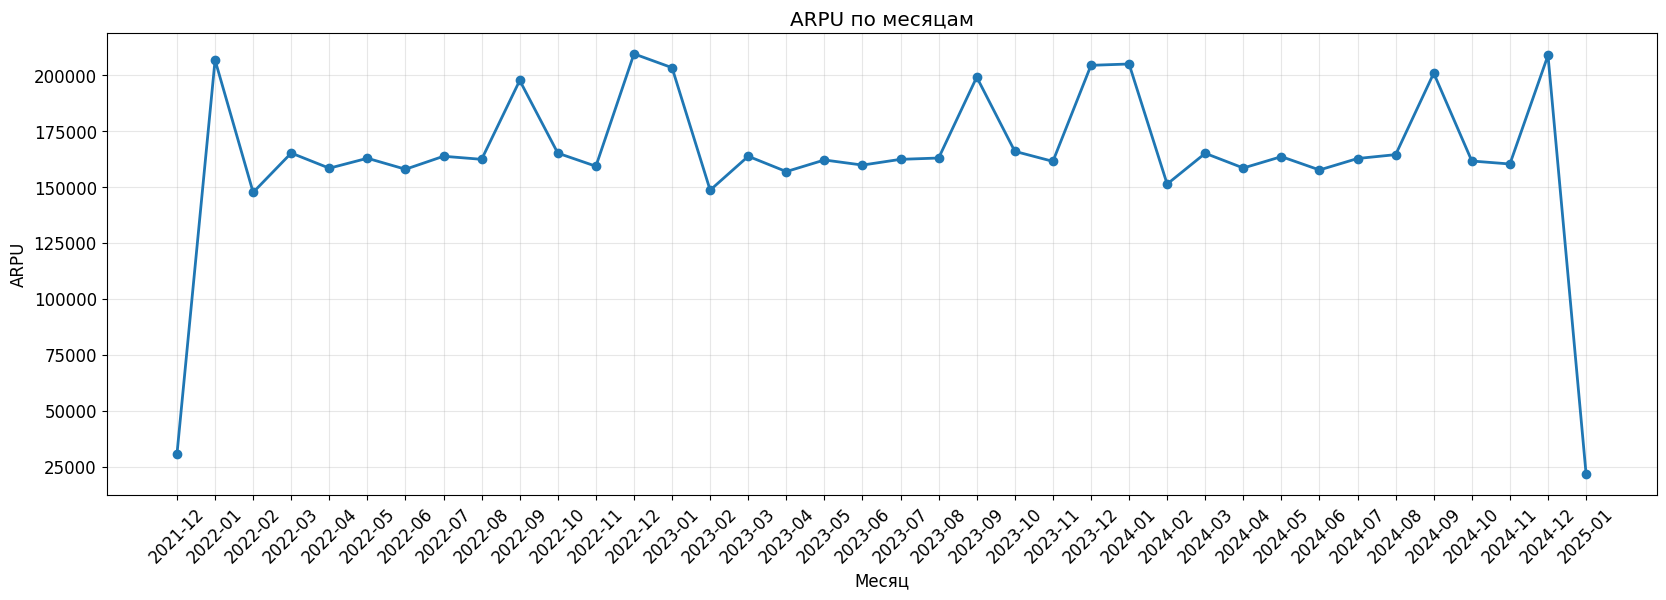

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

# График 1: ARPU по месяцам
plt.subplot(1, 1, 1)
plt.plot(arpu_df['year_month'], arpu_df['ARPU'], marker='o', linewidth=2)
plt.title('ARPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ARPU')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)





/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_1445/3337798331.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(arpu_df['year_month'], rotation=45)


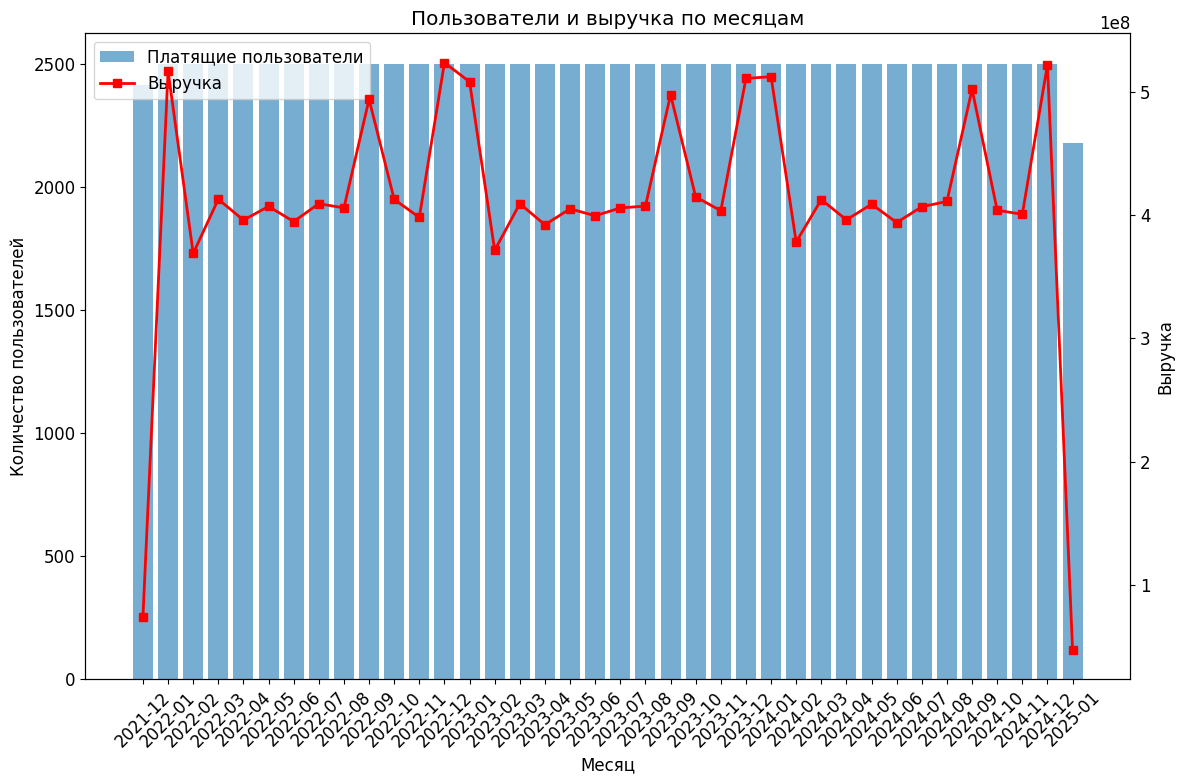

In [9]:
# График 2: Количество платящих пользователей и выручка
plt.subplot(1, 1, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.bar(arpu_df['year_month'], arpu_df['unique_payers'], alpha=0.6, label='Платящие пользователи')
ax2.plot(arpu_df['year_month'], arpu_df['total_revenue'], color='red', marker='s', 
         linewidth=2, label='Выручка')

ax1.set_xlabel('Месяц')
ax1.set_ylabel('Количество пользователей')
ax2.set_ylabel('Выручка')
ax1.set_title('Пользователи и выручка по месяцам')
ax1.set_xticklabels(arpu_df['year_month'], rotation=45)

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [12]:

# Предполагаем, что df уже загружен и timestamp преобразован
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

# ARPPU расчет
arppu_results = []

for month in sorted(df['year_month'].unique()):
    month_data = df[df['year_month'] == month]
    
    # 1. Фильтруем только платящих пользователей (value > 0)
    paying_data = month_data[month_data['value'] > 0]
    
    if len(paying_data) > 0:
        # 2. Общая выручка за месяц
        total_revenue = paying_data['value'].sum()
        
        # 3. Уникальные платящие пользователи
        paying_users = paying_data['userid'].nunique()
        
        # 4. ARPPU
        arppu = total_revenue / paying_users
        
        # Дополнительные метрики
        avg_transactions_per_user = len(paying_data) / paying_users
        avg_value_per_transaction = paying_data['value'].mean()
        
        arppu_results.append({
            'year_month': month,
            'total_revenue': total_revenue,
            'paying_users': paying_users,
            'ARPPU': arppu,
            'transactions_count': len(paying_data),
            'avg_transactions_per_user': avg_transactions_per_user,
            'avg_value_per_transaction': avg_value_per_transaction
        })
    else:
        arppu_results.append({
            'year_month': month,
            'total_revenue': 0,
            'paying_users': 0,
            'ARPPU': 0,
            'transactions_count': 0,
            'avg_transactions_per_user': 0,
            'avg_value_per_transaction': 0
        })

arppu_df = pd.DataFrame(arppu_results)

print("=" * 80)
print("ARPPU (Average Revenue Per Paying User) по месяцам:")
print("=" * 80)
print(arppu_df.to_string(index=False))

ARPPU (Average Revenue Per Paying User) по месяцам:
year_month  total_revenue  paying_users         ARPPU  transactions_count  avg_transactions_per_user  avg_value_per_transaction
   2021-12   7.424609e+07          1433  51811.649546                3921                   2.736218               18935.499566
   2022-01   5.169183e+08          2496 207098.675470               27399                  10.977163               18866.319719
   2022-02   3.690424e+08          2494 147972.083577               24871                   9.972334               14838.260482
   2022-03   4.129888e+08          2494 165592.925706               28011                  11.231355               14743.806244
   2022-04   3.960662e+08          2497 158616.830453               26702                  10.693632               14832.829962
   2022-05   4.071707e+08          2492 163391.129571               27617                  11.082263               14743.480280
   2022-06   3.948901e+08          2490 158590.41420

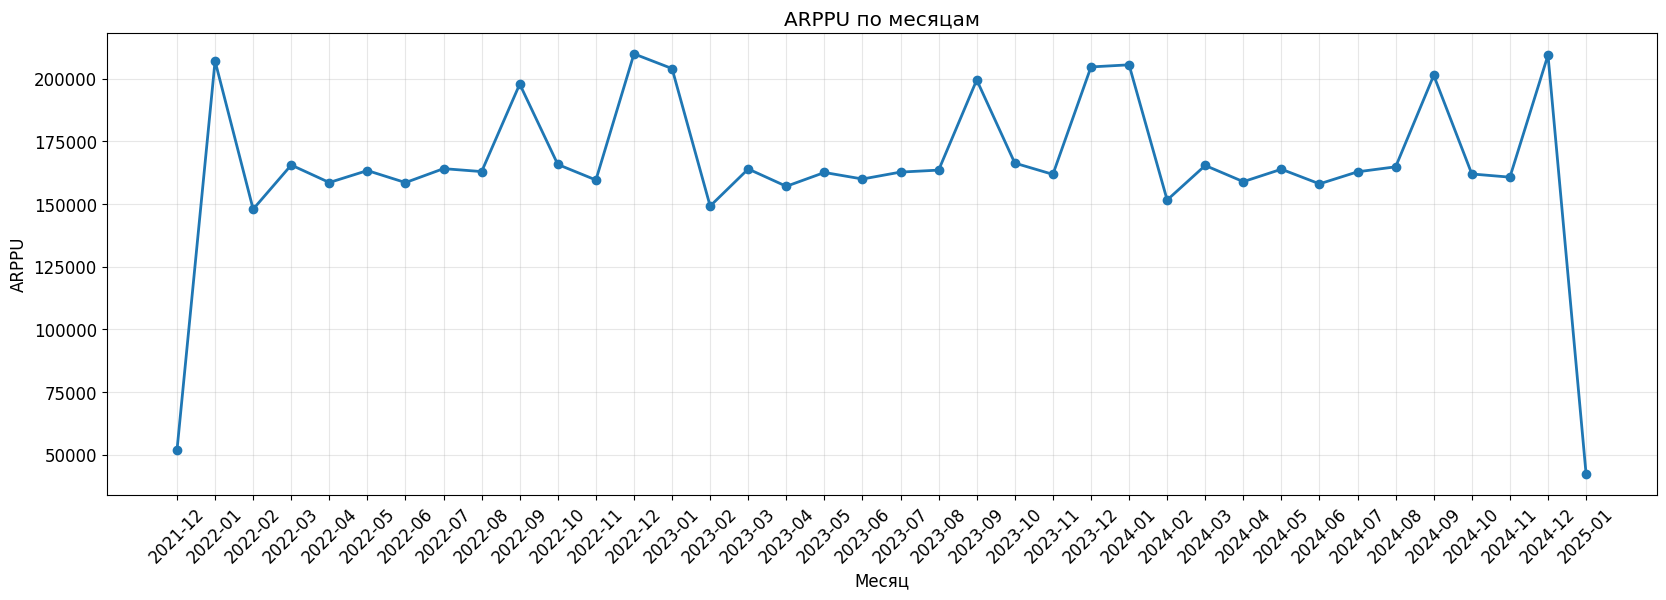

In [14]:
plt.figure(figsize=(20, 6))

# График 1: ARPPU по месяцам
plt.subplot(1, 1, 1)
plt.plot(arppu_df['year_month'], arppu_df['ARPPU'], marker='o', linewidth=2)
plt.title('ARPPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ARPPU')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


In [15]:
# Сначала считаем ARPU (все пользователи)
arpu_results = []

for month in sorted(df['year_month'].unique()):
    month_data = df[df['year_month'] == month]
    
    # Все пользователи в месяце
    all_users = month_data['userid'].nunique()
    
    # Выручка от платящих пользователей
    paying_data = month_data[month_data['value'] > 0]
    total_revenue = paying_data['value'].sum()
    paying_users = paying_data['userid'].nunique()
    
    # ARPU (все пользователи)
    arpu = total_revenue / all_users if all_users > 0 else 0
    
    # ARPPU (только платящие)
    arppu = total_revenue / paying_users if paying_users > 0 else 0
    
    arpu_results.append({
        'year_month': month,
        'all_users': all_users,
        'paying_users': paying_users,
        'conversion_rate': (paying_users / all_users * 100) if all_users > 0 else 0,
        'total_revenue': total_revenue,
        'ARPU': arpu,
        'ARPPU': arppu,
        'difference': arppu - arpu
    })

comparison_df = pd.DataFrame(arpu_results)

print("\n" + "=" * 90)
print("Сравнение ARPU и ARPPU:")
print("=" * 90)
print(comparison_df.to_string(index=False))

# Сводная статистика
print("\n📊 Сводная статистика за весь период:")
print(f"Средний ARPU: {comparison_df['ARPU'].mean():.2f}")
print(f"Средний ARPPU: {comparison_df['ARPPU'].mean():.2f}")
print(f"Средняя конверсия в платящих: {comparison_df['conversion_rate'].mean():.1f}%")
print(f"Разница ARPPU - ARPU: {comparison_df['ARPPU'].mean() - comparison_df['ARPU'].mean():.2f}")


Сравнение ARPU и ARPPU:
year_month  all_users  paying_users  conversion_rate  total_revenue          ARPU         ARPPU   difference
   2021-12       2415          1433        59.337474   7.424609e+07  30743.724141  51811.649546 21067.925406
   2022-01       2500          2496        99.840000   5.169183e+08 206767.317589 207098.675470   331.357881
   2022-02       2500          2494        99.760000   3.690424e+08 147616.950576 147972.083577   355.133001
   2022-03       2500          2494        99.760000   4.129888e+08 165195.502684 165592.925706   397.423022
   2022-04       2500          2497        99.880000   3.960662e+08 158426.490256 158616.830453   190.340197
   2022-05       2500          2492        99.680000   4.071707e+08 162868.277956 163391.129571   522.851615
   2022-06       2500          2490        99.600000   3.948901e+08 157956.052544 158590.414201   634.361657
   2022-07       2500          2494        99.760000   4.094091e+08 163763.657128 164157.635453   393.9

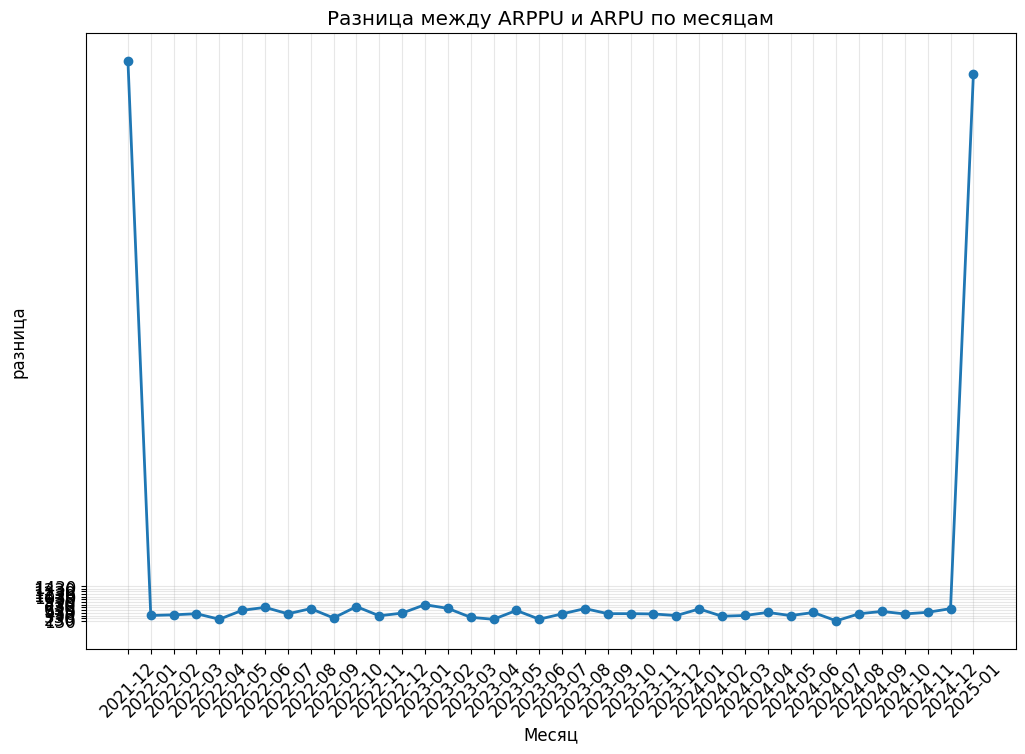

In [25]:
import numpy as np

plt.plot(comparison_df['year_month'], comparison_df['difference'], marker='o', linewidth=2)
plt.title('Разница между ARPPU и ARPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('разница')
plt.xticks(rotation=45)
plt.yticks(np.arange(min(comparison_df['difference']), comparison_df["difference"].mean(), 100))
plt.grid(True, alpha=0.3)